# Libraries

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Lambda
from keras import backend as K
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [2]:
#Remove existing txt files
#rm *.txt

In [3]:
#See what you have in your current directory
#ls

# Functions and Parameters 

In [4]:
def sigma_calc(a):
    return np.sqrt(1/(2*10**(a/10)))
    
def modulateBPSK(x): # 0 -> 1,  1 -> -1
    return -2*x +1;

def addNoise(x, sigma):
    w = K.random_normal(K.shape(x), mean=0.0, stddev=sigma)
    return x + w

def addNoise_RC(x, sigma):
    w = np.random.normal(0, sigma, x.shape)
    return x + w

def ber(y_true, y_pred):
    return K.mean(K.not_equal(y_true, K.round(y_pred)))

def return_output_shape(input_shape):  
    return input_shape

def compose_model(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    return model

def Encoder31_RC(x): # 0->000, 1->111
  return np.array([[it for it in item for i in range(3)] for item in x])

def SoftDecisionDecoder_RC(x): # 0->111, 1->000 
  res=[]
  n=x.shape[1]//3
  for item in x:
    subres=[]
    for i in range(n):
        subres.append(int(np.sum(item[3*i:3*i+3])<0)) # if sum of 3 values < 0 then code is 1 otherwise 0
    res.append(subres)
  return res

def ber_RC(y_true, y_pred):
    return np.mean(np.not_equal(y_true,y_pred))

def HardDecisionDecoder_RC(x):
  res=[]
  n=x.shape[1]//3
  for item in x:
    subres=[]
    for i in range(n):
      subres.append(int(np.sum((item[3*i:3*i+3]>0).astype(int))<=1)) # if majority bit is 1 then code is 1 otherwise 0
    res.append(subres)
  return res

In [5]:
k = 8                        # number of information bits
N = 4*k                      # code length r=k/N
train_SNR_Eb = 1             # training-Eb/No
power=10
nb_epoch = 2**power          # number of learning epochs
nn_structure = [128, 64, 32] # each list entry defines the number of nodes in a layer
batch_size = 256             # size of batches for calculation the gradient
log10KN=np.log10(k/N)
train_SNR_Es = train_SNR_Eb + 10*log10KN
train_sigma = sigma_calc(train_SNR_Es)

# Define Neural Network Model

In [6]:
# Define modulator
modulator_layers = [Lambda(modulateBPSK, input_shape=(N,), output_shape=return_output_shape, name="modulator")]
modulator = compose_model(modulator_layers)
modulator.compile(optimizer='adam', loss='mse')

# Define noise
noise_layers = [Lambda(addNoise, arguments={'sigma':train_sigma}, input_shape=(N,), output_shape=return_output_shape, name="noise")]
noise = compose_model(noise_layers)
noise.compile(optimizer='adam', loss='mse')

# Define decoder 
decoder_layers = [Dense(nn_structure[0], activation='relu', input_shape=(N,))]
for i in range(1,len(nn_structure)):
    decoder_layers.append(Dense(nn_structure[i], activation='relu'))
decoder_layers.append(Dense(k, activation='sigmoid'))
decoder = compose_model(decoder_layers)
decoder.compile(optimizer='adam', loss='mse', metrics=[ber])

# Define model
model_layers = modulator_layers + noise_layers + decoder_layers
model = compose_model(model_layers)
model.compile(optimizer='adam', loss='mse')

# Data Generation

In [7]:
def AllPossInforWords(m):
  res = np.zeros((2**m, m),dtype=bool)
  for i, t in enumerate(itertools.product([0, 1], repeat=m)):
    res[i] = list(t)
  return res

def bin_to_int(x):
  n=len(x)
  value = [x[i] * 2 ** (n-i-1) for i in range(n)]
  return np.sum(value).astype(int)

In [8]:
# Create all possible information words
d=AllPossInforWords(k)
# Create sets of all possible codewords
np.random.seed(212)   
x = np.random.randint(0,2,size=(2**k,N), dtype=bool)

# Neural Network Training

In [9]:
model.summary()
history = model.fit(x, d, batch_size=batch_size, epochs=nb_epoch, verbose=0, shuffle=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
modulator (Lambda)           (None, 32)                0         
_________________________________________________________________
noise (Lambda)               (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               4224      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
Total params: 14,824
Trainable params: 14,824
Non-trainable params: 0
__________________________________________________

# Neural Network and Repetition Code Testing

In [10]:
test_batch = 2**9  
num_words = 2**12      
SNR_dB_start_Eb = 0
SNR_dB_stop_Eb = 5
SNR_points = 10

SNR_dB_start_Es = SNR_dB_start_Eb + 10*log10KN
SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*log10KN

sigma_start = sigma_calc(SNR_dB_start_Es)
sigma_stop = sigma_calc(SNR_dB_stop_Es)

sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)

nb_errorsNN = np.zeros(SNR_points,dtype=float)
nb_errorsRCSD = np.zeros(SNR_points,dtype=float)
nb_errorsRCHD = np.zeros(SNR_points,dtype=float)
nb_bits = np.full(SNR_points, k*num_words)

for i in range(SNR_points):
    for j in range(num_words//test_batch):
        # Source
        np.random.seed(0)
        d_test = np.random.randint(0,2,size=(test_batch, k)) 

        # Encoder for NN
        x_test = np.zeros((test_batch, N),dtype=bool)
        for p in range(test_batch):
            x_test[p] = x[bin_to_int(d_test[p])]
        # Encoder for Repetition Code
        x_testRC = Encoder31_RC(d_test)

        # Modulator (BPSK) for NN
        s_testNN = modulateBPSK(x_test)
        # Modulator (BPSK) for RC
        s_testRC = modulateBPSK(x_testRC)

        # Channel (AWGN) for NN
        y_testNN = addNoise(s_testNN, sigmas[i])
        # Channel (AWGN) for RC
        y_testRC = addNoise_RC(s_testRC, sigmas[i])

        #Decode BER for NN
        nb_errorsNN[i] += decoder.evaluate(y_testNN, d_test, batch_size=test_batch, verbose=0)[1] # BER of Neural Network

        #Decode BER for RC
        Decoded_y_testRC=SoftDecisionDecoder_RC(y_testRC) # Decoding by Soft Decision Decoder
        Decoded_y_testRCHD=HardDecisionDecoder_RC(y_testRC) # Decoding by Hard Decision Decoder
        nb_errorsRCSD[i] += ber_RC(Decoded_y_testRC, d_test) # BER of Soft Decision Decoder
        nb_errorsRCHD[i] += ber_RC(Decoded_y_testRCHD, d_test) # BER of Hard Decision Decoder

In [12]:
#Uncomment to generate more results based on epoches

#st=''
#for i in range(len(nb_errorsNN)):
#  st=st+str(nb_errorsNN[i]/nb_bits[i])+','
#st=st[:-1]

#with open('epoch_2^'+str(power)+'.txt', 'w') as f:
#    print(st, file=f)

# Bit-Error-Rate Plot

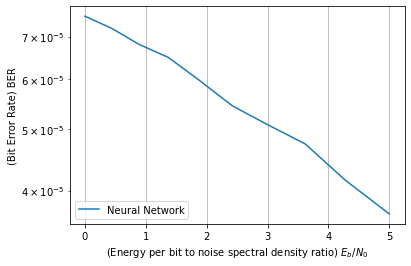

In [13]:
plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*log10KN, nb_errorsNN/nb_bits)
legend = []
legend.append('Neural Network') 
plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('(Energy per bit to noise spectral density ratio) $E_b/N_0$')
plt.ylabel('(Bit Error Rate) BER')    
plt.grid(True)
plt.show()

# Neural Network and Repetition Code Performances Curve

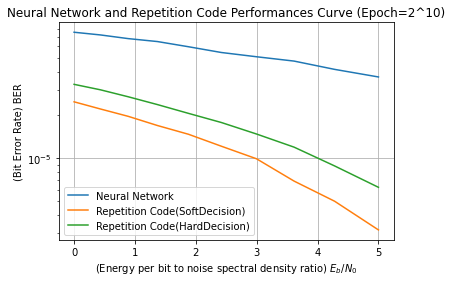

In [14]:
plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*log10KN, nb_errorsNN/nb_bits)
plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*log10KN, nb_errorsRCSD/nb_bits)
plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*log10KN, nb_errorsRCHD/nb_bits)

legend = []
plt.title("Neural Network and Repetition Code Performances Curve (Epoch=2^10)")
legend.append('Neural Network') 
legend.append('Repetition Code(SoftDecision)') 
legend.append('Repetition Code(HardDecision)') 

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('(Energy per bit to noise spectral density ratio) $E_b/N_0$')
plt.ylabel('(Bit Error Rate) BER')    
plt.grid(True)
plt.show()

In [15]:
ls

'epoch_2^10.txt'  'epoch_2^12.txt'  'epoch_2^14.txt'        Previous/
'epoch_2^11.txt'  'epoch_2^13.txt'   Final_ICT_Code.ipynb


In [16]:
#Please load files in the directory, we compiled and generated.
#from google.colab import files
#uploaded = files.upload()

In [17]:
ls

'epoch_2^10.txt'  'epoch_2^12.txt'  'epoch_2^14.txt'        Previous/
'epoch_2^11.txt'  'epoch_2^13.txt'   Final_ICT_Code.ipynb


## Bit-Error-Rate Plot Analysis on Different Epoches

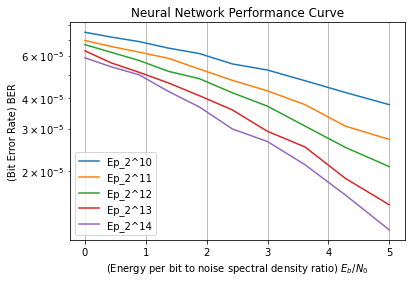

In [18]:
Epoch_map10 = open('epoch_2^10.txt').read()
Epoch_map11 = open('epoch_2^11.txt').read()
Epoch_map12 = open('epoch_2^12.txt').read()
Epoch_map13 = open('epoch_2^13.txt').read()
Epoch_map14 = open('epoch_2^14.txt').read()

Line10 = [float(x) for x in Epoch_map10.split(',')]
Line11 = [float(x) for x in Epoch_map11.split(',')]
Line12 = [float(x) for x in Epoch_map12.split(',')]
Line13 = [float(x) for x in Epoch_map13.split(',')]
Line14 = [float(x) for x in Epoch_map14.split(',')]

plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*log10KN, Line10)
plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*log10KN, Line11)
plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*log10KN, Line12)
plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*log10KN, Line13)
plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*log10KN, Line14)

legend = []
plt.title("Neural Network Performance Curve")
legend.append('Ep_2^10')
legend.append('Ep_2^11')
legend.append('Ep_2^12')
legend.append('Ep_2^13')
legend.append('Ep_2^14')

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('(Energy per bit to noise spectral density ratio) $E_b/N_0$')
plt.ylabel('(Bit Error Rate) BER')    
plt.grid(True)
plt.show()

<i> <b>Reference:</b> T. Gruber, S. Cammerer, J. Hoydis and S. t. Brink, "On deep learning-based channel decoding," 2017 51st Annual Conference on Information Sciences and Systems (CISS), Baltimore, MD, USA, 2017, pp. 1-6, doi: 10.1109/CISS.2017.7926071.</i>